In [9]:
import os
import torch
import numpy as np

from torch.utils.data import TensorDataset, DataLoader, Subset
import torchvision
from os import path

from src.utils import *
from src.models import *
from src.methods import *

data_path = path.join(os.getcwd(), 'project_data/')

USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


In [10]:
X_test = np.load(data_path + "X_test.npy")
y_test = np.load(data_path + "y_test.npy") - 769
person_train_valid = np.load(data_path + "person_train_valid.npy")
X_train_valid = np.load(data_path + "X_train_valid.npy")
y_train_valid = np.load(data_path + "y_train_valid.npy") - 769
person_test = np.load(data_path + "person_test.npy")

In [11]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [12]:
X_train_valid = X_train_valid[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]

In [13]:
X_train_valid = torch.from_numpy(X_train_valid).float()
y_train_valid = torch.from_numpy(y_train_valid).long()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

train_valid_dataset = TensorDataset(X_train_valid, y_train_valid)
test_dataset = TensorDataset(X_test, y_test)

# Splitting the dataset into train and valid sets
num_train = int(0.8 * len(train_valid_dataset))
num_valid = len(train_valid_dataset) - num_train
train_indices, valid_indices = random_split(range(len(train_valid_dataset)), [num_train, num_valid])

train_dataset = Subset(train_valid_dataset, train_indices)
valid_dataset = Subset(train_valid_dataset, valid_indices)

# Wrapping datasets with GaussianNoisyDataset
train_dataset_noisy = GaussianNoisyDataset(train_dataset, mean=0., std=1.)
valid_dataset_noisy = GaussianNoisyDataset(valid_dataset, mean=0., std=1.)
test_dataset_noisy = GaussianNoisyDataset(test_dataset, mean=0., std=1.)

batch_size = 32
train_loader = DataLoader(train_dataset_noisy, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset_noisy, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset_noisy, batch_size=batch_size, shuffle=False)

print('Training/Valid data shape:', X_train_valid.shape)
print('Test data shape:', X_test.shape)

Training/Valid data shape: torch.Size([2115, 1, 22, 1000])
Test data shape: torch.Size([443, 1, 22, 1000])


In [14]:
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas=(0.9, 0.99), eps=1e-6, weight_decay=0.0005)

train(model, train_loader, valid_loader, criterion, optimizer, device=device, epochs=50)

test_accuracy = evaluate(model, test_loader, device=device)
print(f'Test Accuracy: {test_accuracy:.2f}%')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
lstm = LSTMModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr = 0.001, betas=(0.9, 0.99), eps=1e-6, weight_decay=0.0005)

lstm = lstm.to(device)
train(lstm, train_loader, valid_loader, criterion, optimizer, device=device)

test_accuracy = evaluate(lstm, test_loader, device=device)
print(f'Test Accuracy: {test_accuracy:.2f}%')

In [ ]:
cnn_lstm = CNN_LSTM()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_lstm.parameters(), lr = 0.001, betas=(0.9, 0.99), eps=1e-6)

cnn_lstm = cnn_lstm.to(device)
train(cnn_lstm, train_loader, valid_loader, criterion, optimizer, device=device, epochs=50)

test_accuracy = evaluate(cnn_lstm, test_loader, device=device)
print(f'Test Accuracy: {test_accuracy:.2f}%')

In [15]:
ult_cnn = UltimateConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ult_cnn.parameters(), lr = 0.001, betas=(0.9, 0.99), eps=1e-6, weight_decay=0.0005)

ult_cnn = ult_cnn.to(device)
train(ult_cnn, train_loader, valid_loader, criterion, optimizer, device=device, epochs=200)

test_accuracy = evaluate(ult_cnn, test_loader, device=device)
print(f'Test Accuracy: {test_accuracy:.2f}%')

  5%|▌         | 10/200 [00:12<03:54,  1.23s/it]

Epoch [10/200], Loss: 1.1305, Validation Accuracy: 54.61%


 10%|█         | 20/200 [00:24<03:42,  1.23s/it]

Epoch [20/200], Loss: 0.9625, Validation Accuracy: 59.34%


 15%|█▌        | 30/200 [00:36<03:28,  1.23s/it]

Epoch [30/200], Loss: 0.8745, Validation Accuracy: 65.01%


 20%|██        | 40/200 [00:48<03:16,  1.23s/it]

Epoch [40/200], Loss: 0.8137, Validation Accuracy: 66.67%


 25%|██▌       | 50/200 [01:00<03:04,  1.23s/it]

Epoch [50/200], Loss: 0.7285, Validation Accuracy: 69.27%


 30%|███       | 60/200 [01:12<02:52,  1.23s/it]

Epoch [60/200], Loss: 0.7321, Validation Accuracy: 70.21%


 35%|███▌      | 70/200 [01:24<02:39,  1.23s/it]

Epoch [70/200], Loss: 0.6819, Validation Accuracy: 69.27%


 40%|████      | 80/200 [01:36<02:23,  1.20s/it]

Epoch [80/200], Loss: 0.6336, Validation Accuracy: 67.85%


 45%|████▌     | 90/200 [01:47<02:14,  1.22s/it]

Epoch [90/200], Loss: 0.6137, Validation Accuracy: 70.21%


 46%|████▌     | 92/200 [01:51<02:10,  1.21s/it]

Early stopping!
Test Accuracy: 69.98%


In [ ]:
# utilize ray tune to find best hyperparameters
import ray
from ray import tune
from ray import train as raytrain
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from src.methods_ray import train_ray_Ultimateconfig

config = {
    'lr': tune.loguniform(1e-4, 1e-2),
    'weight_decay': tune.loguniform(1e-4, 1e-3)
}

# Initialize Ray Tune
ray.shutdown()
ray.init()
scheduler = ASHAScheduler(metric='loss', mode='min')
reporter = CLIReporter(metric_columns=['loss'])

# Execute the hyperparameter search
analysis = tune.run(
    train_ray_Ultimateconfig,
    resources_per_trial={'gpu': 1},  # If you want to use GPUs, you can set {'gpu': 1} instead
    config=config,
    num_samples=100,
    scheduler=scheduler,
    progress_reporter=reporter
)

# Get the best hyperparameters
best_config = analysis.get_best_config(metric='loss', mode='min')
print('Best hyperparameters found are: ', best_config)

# get best accuracy using tune config


In [ ]:
# run with best hyperparameters
ult_cnn = UltimateConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ult_cnn.parameters(), lr = best_config['lr'].real, betas=(0.9, 0.99), eps=1e-6, weight_decay=best_config['weight_decay'].real)

ult_cnn = ult_cnn.to(device)
train(ult_cnn, train_loader, valid_loader, criterion, optimizer, device=device, epochs=100,patience=100)

test_accuracy = evaluate(ult_cnn, test_loader, device=device)
print(f'Test Accuracy: {test_accuracy:.2f}%')

NameError: name 'best_config' is not defined

In [17]:
import ray
from ray import tune
from ray import train as raytrain
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from src.methods_ray import train_ray_Ultimateconfig
from ray.tune.search.bayesopt import BayesOptSearch
ray.shutdown()
ray.init()
scheduler = ASHAScheduler(metric='loss', mode='min', max_t= 250)
reporter = CLIReporter(metric_columns=['loss'])
bayesopt = BayesOptSearch(
    metric='loss',
    mode='min',
)

# config = {
#     'weight_decay': tune.loguniform(1e-4, 1e-3),
# }

config = {
    'lr': tune.loguniform(1e-4, 1e-2),
}


analysis = tune.run(
    train_ray_Ultimateconfig,
    resources_per_trial={'gpu': 1},  # If you want to use GPUs, you can set {'gpu': 1} instead
    config=config,
    num_samples=20,
    search_alg=bayesopt,
    scheduler=scheduler,
    progress_reporter=reporter
)

# Get the best hyperparameters
best_config = analysis.get_best_config(metric='loss', mode='min')
print('Best hyperparameters found are: ', best_config)

2024-03-08 13:02:29,995	INFO worker.py:1724 -- Started a local Ray instance.
2024-03-08 13:02:31,437	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-03-08 13:02:31,445	WARNING bayesopt_search.py:431 -- BayesOpt does not support specific sampling methods. The LogUniform sampler will be dropped.


== Status ==
Current time: 2024-03-08 13:02:31 (running for 00:00:00.11)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/40 CPUs, 0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 1/20 (1 PENDING)


== Status ==
Current time: 2024-03-08 13:02:36 (running for 00:00:05.18)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/40 CPUs, 2.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 2/20 (1 PENDING, 1 RUNNING)




Trial name,loss
train_ray_Ultimateconfig_56e043ae,1.32395
train_ray_Ultimateconfig_701ac564,1.35493
train_ray_Ultimateconfig_7a63cdcd,1.33806
train_ray_Ultimateconfig_991f8802,1.3266
train_ray_Ultimateconfig_9aeb2717,0.868023
train_ray_Ultimateconfig_af0f3193,1.17982
train_ray_Ultimateconfig_bac622f2,1.32235
train_ray_Ultimateconfig_d94a67fe,0.736599
train_ray_Ultimateconfig_e41eba09,1.33737
train_ray_Ultimateconfig_e700eb2c,1.33413


== Status ==
Current time: 2024-03-08 13:02:41 (running for 00:00:10.18)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -1.2542115618996585 | Iter 1.000: -1.3400849969110873
Logical resource usage: 0/40 CPUs, 4.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 4/20 (1 PENDING, 3 RUNNING)


== Status ==
Current time: 2024-03-08 13:02:46 (running for 00:00:15.28)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -1.2320876905681393 | Iter 1.000: -1.3220568923521832
Logical resource usage: 0/40 CPUs, 5.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 5/20 (1 PENDING, 4 RUNNING)




2024-03-08 13:02:48,312	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0016443457513284064}.


== Status ==
Current time: 2024-03-08 13:02:51 (running for 00:00:20.32)
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -1.2040060765636165 | Iter 1.000: -1.3223484075379428
Logical resource usage: 0/40 CPUs, 4.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 6/20 (1 PENDING, 3 RUNNING, 2 TERMINATED)


== Status ==
Current time: 2024-03-08 13:02:56 (running for 00:00:25.33)
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: -1.1680584864131667 | Iter 4.000: -1.2040060765636165 | Iter 1.000: -1.322748314052045
Logical resource usage: 0/40 CPUs, 5.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 8/20 (1 PENDING, 4 RUNNING, 3 TERMINATED)


== Status ==
Current time: 2024-03-08 13:03:01 (running for 00:00:30.41)
Using AsyncHype

2024-03-08 13:03:09,030	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.00969888781486913}.


== Status ==
Current time: 2024-03-08 13:03:12 (running for 00:00:40.56)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: -1.095727324415324 | Iter 4.000: -1.2040060765636165 | Iter 1.000: -1.3246102166795843
Logical resource usage: 0/40 CPUs, 2.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 10/20 (2 RUNNING, 8 TERMINATED)




2024-03-08 13:03:12,307	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.003319314888064796}.
2024-03-08 13:03:12,408	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.007323101165546835}.
2024-03-08 13:03:14,932	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.008100391757687729}.
2024-03-08 13:03:16,000	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.004328367107399938}.


== Status ==
Current time: 2024-03-08 13:03:17 (running for 00:00:45.62)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: -1.095727324415324 | Iter 4.000: -1.2040060765636165 | Iter 1.000: -1.3246102166795843
Logical resource usage: 0/40 CPUs, 2.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 10/20 (2 RUNNING, 8 TERMINATED)




2024-03-08 13:03:19,493	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.006371944136532858}.
2024-03-08 13:03:19,949	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0019465332529585572}.


== Status ==
Current time: 2024-03-08 13:03:22 (running for 00:00:50.69)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: -1.095727324415324 | Iter 4.000: -1.2040060765636165 | Iter 1.000: -1.3246102166795843
Logical resource usage: 0/40 CPUs, 2.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 10/20 (2 RUNNING, 8 TERMINATED)




2024-03-08 13:03:22,388	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.006367704427005353}.
2024-03-08 13:03:22,791	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.008981391573530513}.
2024-03-08 13:03:22,892	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.00888215560022466}.
2024-03-08 13:03:23,295	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0017001242695366765}.
2024-03-08 13:03:23,758	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.000150109680077565}.
2024-03-08 13:03:24,462	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0024487659662183205}.
2024-03-08 13:03:24,514	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0033214570117767505}.
2024-03-08 13:03:25,125	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.003740386450288392}.
2024-03-08 13:03:25,813	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.00

== Status ==
Current time: 2024-03-08 13:03:27 (running for 00:00:55.73)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: -1.095727324415324 | Iter 4.000: -1.2040060765636165 | Iter 1.000: -1.3246102166795843
Logical resource usage: 0/40 CPUs, 2.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 10/20 (2 RUNNING, 8 TERMINATED)




2024-03-08 13:03:28,142	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.009367932264191732}.
2024-03-08 13:03:28,947	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.00878599341208676}.
2024-03-08 13:03:29,611	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.008684015953943027}.
2024-03-08 13:03:29,812	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.005162289748723285}.
2024-03-08 13:03:30,114	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.006534642914699876}.
2024-03-08 13:03:30,215	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.007049472084851264}.
2024-03-08 13:03:30,576	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0010304212044246032}.
2024-03-08 13:03:30,979	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.005472181883605009}.
2024-03-08 13:03:31,180	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0059

== Status ==
Current time: 2024-03-08 13:03:32 (running for 00:01:00.73)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: -1.095727324415324 | Iter 4.000: -1.2040060765636165 | Iter 1.000: -1.3246102166795843
Logical resource usage: 0/40 CPUs, 2.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 10/20 (2 RUNNING, 8 TERMINATED)




2024-03-08 13:03:32,483	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.006410556024832246}.
2024-03-08 13:03:32,584	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.00728830420385435}.
2024-03-08 13:03:32,812	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.003297269082118335}.
2024-03-08 13:03:32,861	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.007972343328210167}.
2024-03-08 13:03:33,264	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0003509723598130294}.
2024-03-08 13:03:33,365	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.009630219305311459}.
2024-03-08 13:03:33,566	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.006990144640327611}.
2024-03-08 13:03:34,654	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.006156035387720088}.
2024-03-08 13:03:35,243	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0012

== Status ==
Current time: 2024-03-08 13:03:37 (running for 00:01:05.80)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: -1.095727324415324 | Iter 4.000: -1.2040060765636165 | Iter 1.000: -1.3246102166795843
Logical resource usage: 0/40 CPUs, 2.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 10/20 (2 RUNNING, 8 TERMINATED)




2024-03-08 13:03:37,589	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.00940827939010708}.
2024-03-08 13:03:38,541	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.002038332234414035}.
2024-03-08 13:03:38,655	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.001097702213636524}.
2024-03-08 13:03:38,832	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0010349853114836913}.
2024-03-08 13:03:39,034	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0008047676197562671}.
2024-03-08 13:03:39,738	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.006997697937105092}.
2024-03-08 13:03:39,924	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.008786972933917824}.
2024-03-08 13:03:40,131	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0028921422684559345}.
2024-03-08 13:03:40,433	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.00

== Status ==
Current time: 2024-03-08 13:03:42 (running for 00:01:10.89)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: -1.095727324415324 | Iter 4.000: -1.2040060765636165 | Iter 1.000: -1.3246102166795843
Logical resource usage: 0/40 CPUs, 2.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 10/20 (2 RUNNING, 8 TERMINATED)




2024-03-08 13:03:42,626	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.009511010754681805}.
2024-03-08 13:03:42,828	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.006355188400481013}.
2024-03-08 13:03:43,606	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0010029404201820347}.
2024-03-08 13:03:43,707	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.004994761016555558}.
2024-03-08 13:03:43,909	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.005540335935004983}.
2024-03-08 13:03:44,513	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.007638955254002976}.
2024-03-08 13:03:44,678	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0011011144936156235}.
2024-03-08 13:03:44,779	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0009326573805384747}.
2024-03-08 13:03:44,986	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0

== Status ==
Current time: 2024-03-08 13:03:47 (running for 00:01:15.90)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: -1.095727324415324 | Iter 4.000: -1.2040060765636165 | Iter 1.000: -1.3246102166795843
Logical resource usage: 0/40 CPUs, 2.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 10/20 (2 RUNNING, 8 TERMINATED)




2024-03-08 13:03:47,551	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0038112187372846703}.
2024-03-08 13:03:47,954	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.009635903140462053}.
2024-03-08 13:03:48,108	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.009701800384405627}.
2024-03-08 13:03:48,527	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0008305859908804489}.
2024-03-08 13:03:48,728	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.00969609510262908}.
2024-03-08 13:03:48,829	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.005278668657284474}.
2024-03-08 13:03:48,931	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0063310465175391}.
2024-03-08 13:03:49,031	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.006987912020947711}.
2024-03-08 13:03:49,288	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.00588

== Status ==
Current time: 2024-03-08 13:03:52 (running for 00:01:20.93)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: -1.095727324415324 | Iter 4.000: -1.2040060765636165 | Iter 1.000: -1.3246102166795843
Logical resource usage: 0/40 CPUs, 2.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 10/20 (2 RUNNING, 8 TERMINATED)




2024-03-08 13:03:52,777	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.009702152538364572}.
2024-03-08 13:03:53,018	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0047400622819702065}.
2024-03-08 13:03:53,248	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0006581174168441785}.
2024-03-08 13:03:53,450	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.008147719990387768}.
2024-03-08 13:03:53,752	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.005598773885466013}.
2024-03-08 13:03:54,004	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.008511509167706374}.
2024-03-08 13:03:54,105	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.002548746207257657}.
2024-03-08 13:03:54,327	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.009545105169861352}.
2024-03-08 13:03:54,428	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.00

== Status ==
Current time: 2024-03-08 13:03:57 (running for 00:01:25.94)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: -0.945634792037044 | Iter 16.000: -1.095727324415324 | Iter 4.000: -1.2040060765636165 | Iter 1.000: -1.3246102166795843
Logical resource usage: 0/40 CPUs, 2.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 10/20 (2 RUNNING, 8 TERMINATED)




2024-03-08 13:03:57,763	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.004971951301487428}.
2024-03-08 13:03:57,864	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0026566194441596876}.
2024-03-08 13:03:58,167	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.00497691913052941}.
2024-03-08 13:03:58,268	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0033546409418463313}.
2024-03-08 13:03:58,369	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.006370668457735586}.
2024-03-08 13:03:58,671	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0013759092469154276}.
2024-03-08 13:03:59,038	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0019006128355515339}.
2024-03-08 13:03:59,240	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.008978205258069517}.
2024-03-08 13:03:59,341	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0

== Status ==
Current time: 2024-03-08 13:04:02 (running for 00:01:30.95)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: -0.8256242992818779 | Iter 16.000: -1.095727324415324 | Iter 4.000: -1.2040060765636165 | Iter 1.000: -1.3246102166795843
Logical resource usage: 0/40 CPUs, 2.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 10/20 (2 RUNNING, 8 TERMINATED)




2024-03-08 13:04:02,674	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.008962547693103274}.
2024-03-08 13:04:02,775	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.005165606676945095}.
2024-03-08 13:04:03,177	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.00537291093790473}.
2024-03-08 13:04:03,278	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.002500457985983824}.
2024-03-08 13:04:03,571	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.00029870485799949107}.
2024-03-08 13:04:03,949	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0012856451050105872}.
2024-03-08 13:04:04,050	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.00891622007932496}.
2024-03-08 13:04:04,151	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.005976565290185082}.
2024-03-08 13:04:05,023	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.001

== Status ==
Current time: 2024-03-08 13:04:07 (running for 00:01:36.03)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: -0.8256242992818779 | Iter 16.000: -1.095727324415324 | Iter 4.000: -1.2040060765636165 | Iter 1.000: -1.3246102166795843
Logical resource usage: 0/40 CPUs, 2.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 10/20 (2 RUNNING, 8 TERMINATED)


== Status ==
Current time: 2024-03-08 13:04:12 (running for 00:01:41.06)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: -0.8256242992818779 | Iter 16.000: -1.095727324415324 | Iter 4.000: -1.2040060765636165 | Iter 1.000: -1.3246102166795843
Logical resource usage: 0/40 CPUs, 2.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 10/20 (2 RUNNING, 8 TERMINATED)


== Status ==
Current time: 2024-03-08 13:04:17 (running for 00:0

2024-03-08 13:06:42,050	INFO tune.py:1042 -- Total run time: 250.61 seconds (250.60 seconds for the tuning loop).


== Status ==
Current time: 2024-03-08 13:06:42 (running for 00:04:10.60)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: -0.8256242992818779 | Iter 16.000: -1.095727324415324 | Iter 4.000: -1.2040060765636165 | Iter 1.000: -1.3246102166795843
Logical resource usage: 0/40 CPUs, 1.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 10/20 (10 TERMINATED)
+-----------------------------------+------------+----------------------+-------------+----------+
| Trial name                        | status     | loc                  |          lr |     loss |
|-----------------------------------+------------+----------------------+-------------+----------|
| train_ray_Ultimateconfig_9aeb2717 | TERMINATED | 131.179.88.212:29487 | 0.00380795  | 0.868023 |
| train_ray_Ultimateconfig_af0f3193 | TERMINATED | 131.179.88.212:29560 | 0.00951207  | 1.17982  |
| train_ray_Ultimateconfig_d94a67fe | TERMINATED 

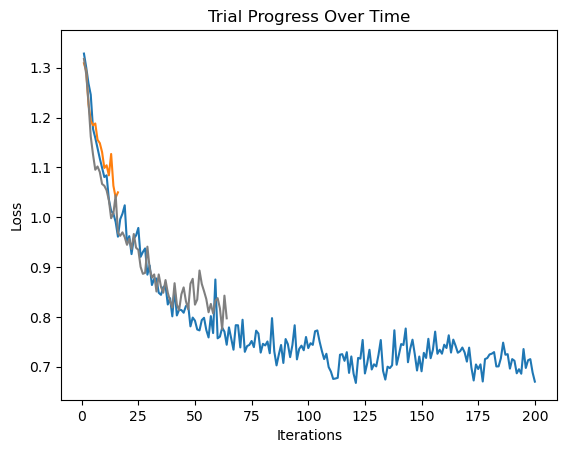

In [13]:
dfs = analysis.trial_dataframes
import matplotlib.pyplot as plt

for d in dfs.values():
    # TODO: Plot the results
    plt.plot(d['training_iteration'], d['loss'], label=d['config/weight_decay'][0])

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Trial Progress Over Time')
plt.show()

In [11]:
# run with best hyperparameters
ult_cnn = UltimateConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ult_cnn.parameters(), lr = 0.00734, betas=(0.9, 0.99), eps=1e-6, weight_decay=0.0004370)

ult_cnn = ult_cnn.to(device)
train(ult_cnn, train_loader, valid_loader, criterion, optimizer, device=device, epochs=200,patience=40)

test_accuracy = evaluate(ult_cnn, test_loader, device=device)
print(f'Test Accuracy: {test_accuracy:.2f}%')

  0%|          | 0/200 [00:00<?, ?it/s]

  5%|▌         | 10/200 [00:11<03:47,  1.20s/it]

Epoch [10/200], Loss: 1.1349, Validation Accuracy: 52.96%


 10%|█         | 20/200 [00:23<03:34,  1.19s/it]

Epoch [20/200], Loss: 1.0746, Validation Accuracy: 51.30%


 15%|█▌        | 30/200 [00:35<03:22,  1.19s/it]

Epoch [30/200], Loss: 0.9756, Validation Accuracy: 62.65%


 20%|██        | 40/200 [00:46<03:18,  1.24s/it]

Epoch [40/200], Loss: 0.9161, Validation Accuracy: 64.54%


 25%|██▌       | 50/200 [00:58<02:59,  1.20s/it]

Epoch [50/200], Loss: 0.9016, Validation Accuracy: 64.30%


 30%|███       | 60/200 [01:10<02:47,  1.19s/it]

Epoch [60/200], Loss: 0.8424, Validation Accuracy: 66.67%


 35%|███▌      | 70/200 [01:22<02:35,  1.19s/it]

Epoch [70/200], Loss: 0.8422, Validation Accuracy: 67.14%


 40%|████      | 80/200 [01:33<02:23,  1.20s/it]

Epoch [80/200], Loss: 0.8537, Validation Accuracy: 67.14%


 45%|████▌     | 90/200 [01:45<02:11,  1.19s/it]

Epoch [90/200], Loss: 0.8197, Validation Accuracy: 67.85%


 50%|█████     | 100/200 [01:57<01:59,  1.20s/it]

Epoch [100/200], Loss: 0.8074, Validation Accuracy: 69.27%


 55%|█████▌    | 110/200 [02:08<01:47,  1.19s/it]

Epoch [110/200], Loss: 0.8270, Validation Accuracy: 68.79%


 60%|██████    | 120/200 [02:20<01:35,  1.19s/it]

Epoch [120/200], Loss: 0.7870, Validation Accuracy: 69.50%


 65%|██████▌   | 130/200 [02:31<01:23,  1.19s/it]

Epoch [130/200], Loss: 0.8020, Validation Accuracy: 68.79%


 70%|███████   | 140/200 [02:43<01:11,  1.19s/it]

Epoch [140/200], Loss: 0.7722, Validation Accuracy: 74.23%


 75%|███████▌  | 150/200 [02:55<00:58,  1.17s/it]

Epoch [150/200], Loss: 0.8024, Validation Accuracy: 69.50%


 80%|████████  | 160/200 [03:06<00:46,  1.17s/it]

Epoch [160/200], Loss: 0.7967, Validation Accuracy: 70.69%


 85%|████████▌ | 170/200 [03:18<00:35,  1.19s/it]

Epoch [170/200], Loss: 0.7948, Validation Accuracy: 66.43%


 90%|█████████ | 180/200 [03:29<00:23,  1.19s/it]

Epoch [180/200], Loss: 0.8270, Validation Accuracy: 69.03%


 94%|█████████▍| 189/200 [03:40<00:12,  1.17s/it]


KeyboardInterrupt: 

In [8]:
vit = ViT(patch_size=(22, 1), num_classes=4, dim=64, num_head=8, num_layers = 2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vit.parameters(), lr=0.01, momentum=0.9)

vit = vit.to(device)
train(vit, train_loader, valid_loader, criterion, optimizer, device=device, epochs=200)

test_accuracy = evaluate(vit, test_loader, device=device)
print(f'Test Accuracy: {test_accuracy:.2f}%')

/home/banyh2000/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
  0%|          | 0/200 [00:02<?, ?it/s]


KeyboardInterrupt: 

torch.Size([2, 64])
